In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
print({most_recent_date})

{'2017-08-23'}


Last date: 2017-08-23 00:00:00
Date one year ago: 2016-08-23 00:00:00


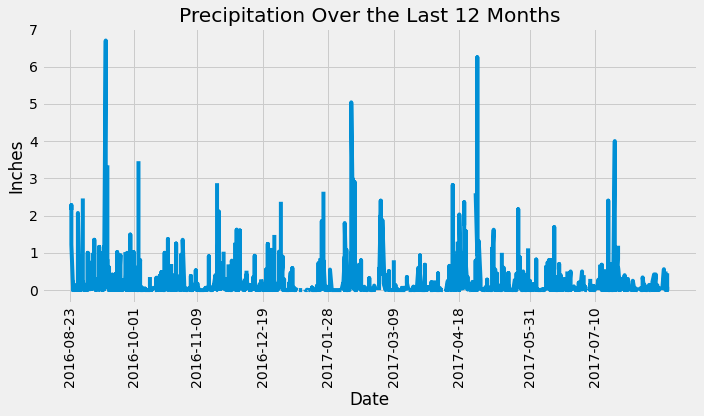

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
if most_recent_date:
    last_date = dt.datetime.strptime(most_recent_date, "%Y-%m-%d") 
    print("Last date:", last_date)
    
# Calculate the date one year from the last date in data set.
    one_year_ago = last_date - dt.timedelta(days=365)
    print("Date one year ago:", one_year_ago)
    
# Perform a query to retrieve the data and precipitation scores
    results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
    df = pd.DataFrame(results, columns=['date', 'precipitation'])

    df['date'] = pd.to_datetime(df['date'])
    
# Sort the dataframe by date   
    df = df.sort_values('date')
    
# Use Pandas Plotting with Matplotlib to plot the data
    xticks_dates = pd.to_datetime(['2016-08-23', '2016-10-01', '2016-11-09', '2016-12-19', '2017-01-28', '2017-03-09', '2017-04-18', '2017-05-31', '2017-07-10'])
    plt.figure(figsize=(10, 6)) 
    plt.plot(df['date'], df['precipitation'])                                
    plt.title("Precipitation Over the Last 12 Months") 
    plt.xlabel("Date") 
    plt.ylabel("Inches")
    plt.xticks(ticks=xticks_dates, labels=xticks_dates.strftime('%Y-%m-%d'), rotation=90)
    plt.tight_layout()
    plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = df['precipitation'].describe()
print(summary_stats)

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station.distinct())).all()
print(total_stations)

[(9,)]


In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_counts = session.query(Measurement.station, func.count(Measurement.station).label('count')) \
                        .group_by(Measurement.station) \
                        .order_by(func.count(Measurement.station).desc()) \
                        .all()

station_counts_df = pd.DataFrame(station_counts, columns=['Station', 'Count'])
print(station_counts_df)

       Station  Count
0  USC00519281   2772
1  USC00519397   2724
2  USC00513117   2709
3  USC00519523   2669
4  USC00516128   2612
5  USC00514830   2202
6  USC00511918   1979
7  USC00517948   1372
8  USC00518838    511


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = session.query(Measurement.station).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()[0]
print(f"Most active station ID: {most_active_station}")

temp_stats = session.query(
    func.min(Measurement.tobs), 
    func.max(Measurement.tobs), 
    func.avg(Measurement.tobs)
).filter(Measurement.station == most_active_station).all()

lowest_temp, highest_temp, avg_temp = temp_stats[0]
print(f"Lowest Temperature: {lowest_temp}")
print(f"Highest Temperature: {highest_temp}")
print(f"Average Temperature: {avg_temp}")

Most active station ID: USC00519281
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


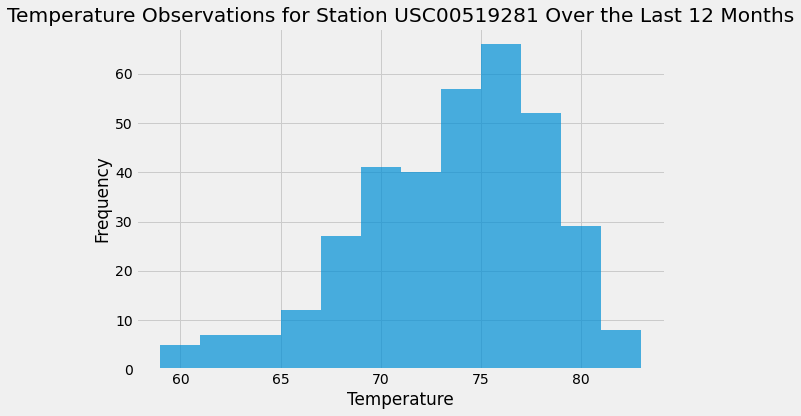

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == most_active_station).filter(Measurement.date >= one_year_ago).all()

df = pd.DataFrame(results, columns=['date', 'temperature'])

plt.figure(figsize=(10, 6)) 

df['temperature'].plot(kind='hist', bins=12, alpha=0.7)

plt.title(f"Temperature Observations for Station {most_active_station} Over the Last 12 Months")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.tight_layout()

plt.show()

# Close Session

In [16]:
# Close Session
session.close()